# Lecture 2 - DBSCAN


Density-based spatial clustering of applications with noise (DBSCAN) a density-based method (duh!) yielding partitional, exclusive and partial clusterings, i.e., each data point is assigned to exactly one cluster or is considered noise (not part of any cluster). 

DBSCAN takes two input parameters: `eps` representing to minimum distance between points in a clusters, and `min_samples` representing the minimum number of data points in a cluster. Both together describe the minimum density of clusters. As we will see in this notebook, identifying good values for both parameters is not obvious and typically requires a good understanding of the data.

Note: This notebook contains some content covered in Lecture 3, particularly the parts of evaluating the quality of clusterings.

## Setting up the notebook

Specify how plots get rendered

In [31]:
%matplotlib notebook

Make all required imports

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import DistanceMetric
from sklearn.metrics.pairwise import euclidean_distances

## Playing with Toy Data

[`sklearn.datasets`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets) provides a series of methods to randomly generate sample data. 

Try different methods and see how the results will change.

In [33]:
X_demo, y_demo = make_blobs(n_samples=100, centers=5, n_features=2, cluster_std=0.85, random_state=11)
X_demo = X_demo/10 # only needed for make_blobs to have a range from -1 to 1 as well (otherwise the eps value would differ too much for different datasets)

#X_demo, y_demo = make_moons(n_samples=250, noise=0.105, random_state=0)
#X_demo, y_demo = make_circles(n_samples=500, noise=0.06, factor=0.5, random_state=0)

We can plot the data to get a first idea how our data looks like. Of course, in practice this might not be (trivially) possible with data points of more then 3 dimensions. The following example, however, focus on illustrating the characteristics of K-Means.

<IPython.core.display.Javascript object>


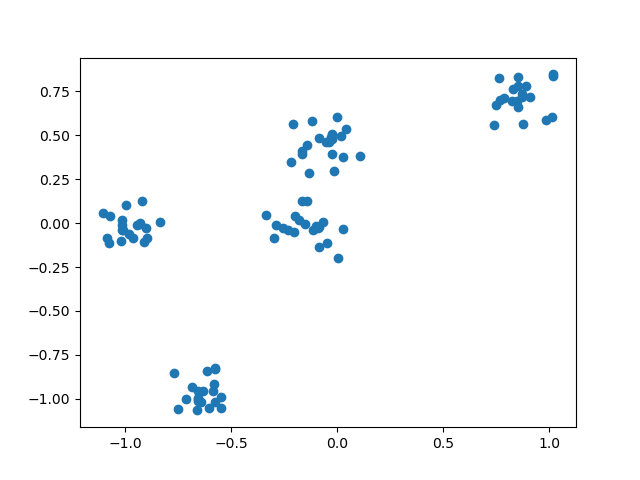

In [34]:
plt.figure()

plt.scatter(X_demo[:,0], X_demo[:,1])

plt.show()

The method below plots the clustering, and we will use it throughout the rest of the notebook. The input of the methods is an instance of [`sklearn.cluster.DBSCAN`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) of calculating the clusters.

<IPython.core.display.Javascript object>


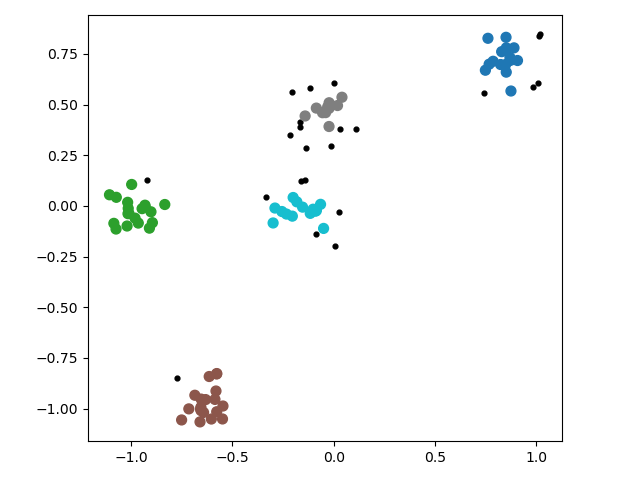

In [35]:
def plot_clusters(dbscan, data, point_size=50, show_ticks=True, aspect=None):
    plt.figure()
    
    # Optionally, set aspect ration (only need for lat/lng data)
    if aspect is not None:
        plt.axes().set_aspect(aspect)
    
    # Get the indices of all the points that belong to a cluster (core or boundary point)
    # (the cluster labels go from 0 to (num_clusters-1)
    cluster_point_indices  = np.where(dbscan.labels_ >= 0)[0]
    
    # Get the list of indices of the noise data points (the label of noise is -1)
    noise_indices = np.where(dbscan.labels_ < 0)[0]
    
    # Plot the noise points in black (throws an error if there's no noise)
    # The dots of noise are smaller and plotted first, so cluster points will always be more prominent
    try:
        plt.scatter(data[noise_indices, 0], data[noise_indices, 1], c='black', s=int(point_size/4))    
    except Exception as e:
        pass

    # Plot clusters, each cluster in a different color (at least w.r.t. to the colormap)
    plt.scatter(data[cluster_point_indices, 0], data[cluster_point_indices, 1], c=dbscan.labels_[cluster_point_indices], s=point_size, cmap=plt.cm.tab10)

    # Optionally, remove all ticks and labels
    if show_ticks is False:
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)  
    
    plt.tight_layout()
    plt.show()
    
dbscan_demo = DBSCAN(eps=0.1, min_samples=8).fit(X_demo) 
plot_clusters(dbscan_demo, X_demo, aspect=1)


Assuming, the blob data, for `eps=0.1` and `min_samples=8`, we can see that some of the outer points of the blobs don't make it into the cluster as the density is to low. Try different parameter values and see how the clustering changes.

### Effects of Different Parameters

With `eps` and `min_samples`, DBSCAN has two core parameters affecting the resulting clustering. So we can use 2 nested loops to vary both parameters over a meaningful ranges. For each parameter setting, we perform DBSCAN and keep track of the resulting silhouette score and the (adjusted) rand index.

In [36]:
silhouette, ari = [], []

for min_samples in np.arange(2, 20.0, 1):
    for eps in np.arange(0.01, 1.0, 0.01):
        
        # Run DBSCAN for the current parameter values
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X_demo) 

        # silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        try:
            silhouette.append((min_samples, eps, silhouette_score(X_demo, dbscan.labels_)))
        except Exception as e:
            pass

        ari.append((min_samples, eps, adjusted_rand_score(y_demo, dbscan.labels_)))
    
# Convert to numpy array for convenience
silhouette = np.array(silhouette)    
ari = np.array(ari)

Having to input parameters, we can visualize the results using a 3d plot. Let's first plot the results for for rand index.

<IPython.core.display.Javascript object>


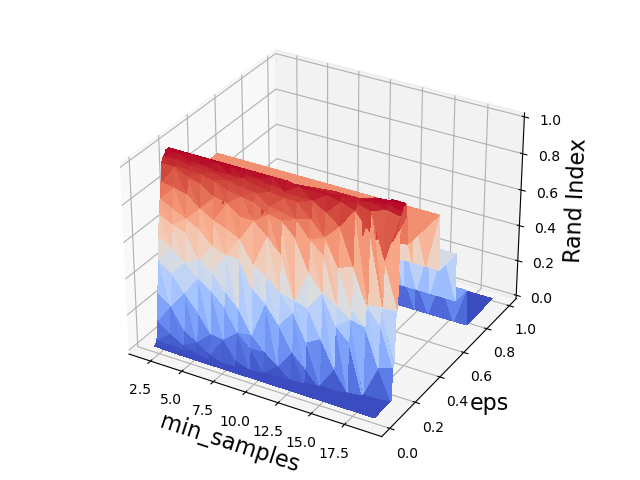

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel(r'min_samples', fontsize=16)
ax.set_ylabel(r'eps', fontsize=16)
ax.set_zlabel('Rand Index', fontsize=16)

surf = ax.plot_trisurf(ari[:,0], ari[:,1], ari[:,2], cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
plt.tight_layout()
plt.show()

**Blobs:** Given the range of the parameters the, the value for `eps` has clearly a greater effect on the result compared to `min_samples`. This is due to the blobs reasonably well separated and of similar density. As soon as an increasing `eps` values crosses a threshold, 2 cluster merge into on -- reflected in the step-by-step reduction in the rand index

Now the plot for the silhouette scores

<IPython.core.display.Javascript object>


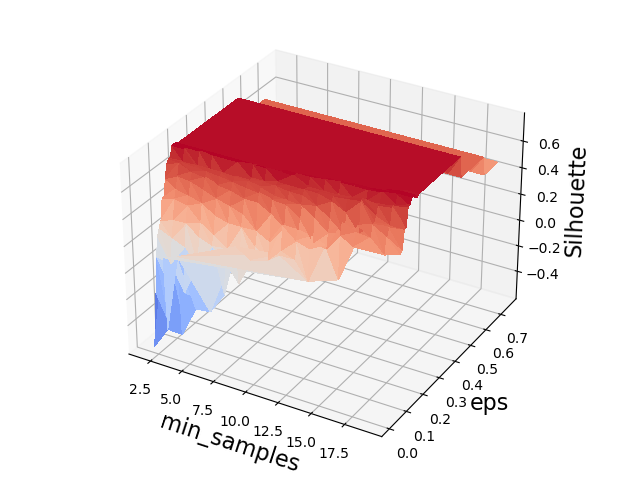

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel(r'min_samples', fontsize=16)
ax.set_ylabel(r'eps', fontsize=16)
ax.set_zlabel('Silhouette', fontsize=16)
surf = ax.plot_trisurf(silhouette[:,0], silhouette[:,1], silhouette[:,2], cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
plt.tight_layout()
plt.show()

**Blobs:** The silhouette score is more stable then the rand index for a range of parameter values, since the calculation of the silhouette score only considers cluster points but NOT noise points. This whether an outer point of a blob is part of the cluster or not, does not make a big difference.

By finding the parameter setting with the highest rand index, we can perform DBSCAN with these setting and plot the results.

<IPython.core.display.Javascript object>


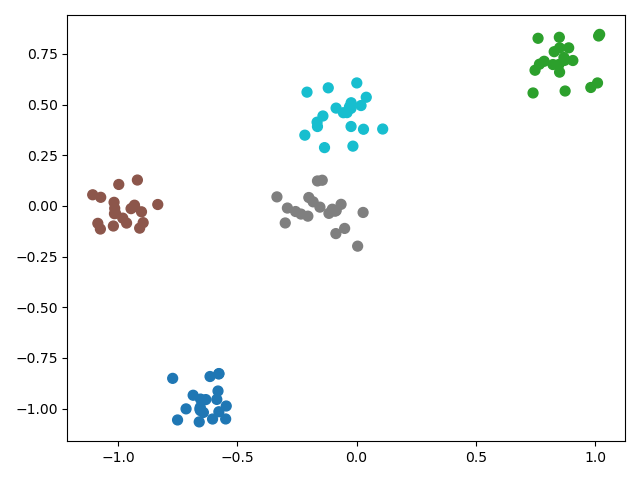

In [39]:
best_run = np.argmax(ari[:,2])
best_min_samples = int(ari[:,0][best_run])
best_eps = ari[:,1][best_run]

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X_demo) 
plot_clusters(dbscan, X_demo)

And we can do the same thing using the silhoutte scores.

<IPython.core.display.Javascript object>


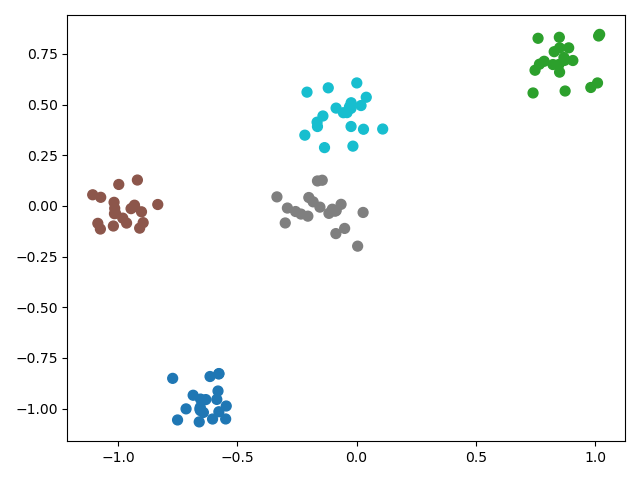

In [40]:
best_run = np.argmax(silhouette[:,2])
best_min_samples = int(silhouette[:,0][best_run])
best_eps = silhouette[:,1][best_run]

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X_demo) 
plot_clusters(dbscan, X_demo)


Note that for the non-blob datasets, the parameter setting resulting in the highest silhouette score does yield the two intuitively preferred clusters. The main reasons is the the silhouette score, similar to SSE, favors blob-like clusters.

## K-Means over a Real-World Dataset (Diabetes)

We first use a publicly available dataset for diabetes prediction: https://www.kaggle.com/uciml/pima-indians-diabetes-database

This is convenient dataset since all attributes for the clustering are numerical, an we can use the default Euclidean distance as similarity measure

### Prepare Data

In [41]:
df_diabetes = pd.read_csv('data/diabetes.csv')

df_diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**Note:** Remember, in practice, you should always do at least a basic EDA to check for missing values and (obvious) outliers! We skip this step to keep the notebook simple.

First, we need to create the input data X for the clustering and -- for this example -- the label data y

In [42]:
X_diabetes = df_diabetes.drop(columns=['Outcome']).to_numpy()
y_diabetes = df_diabetes['Outcome'].to_numpy()

Optionally, we can scale the data. Try with and without scaling and compare the results

In [43]:
scaler = StandardScaler()
X_diabetes = scaler.fit_transform(X_diabetes)

### Estimate Parameter Settings

Selecting meaningful parameters for `eps` and `min_samples` is generally not obvious. One basic approach to get some basic sense for meaningful `eps` values is to look at the distribution of pairwise distances between all data points

In [44]:
# scikit-learn makes it very convenient to calculate pairwise distances
dist = euclidean_distances(X_diabetes, X_diabetes)

# Matrix dist is symmentrical so we can ignore half of it
# (including the diagonal where all values a 0)
dist = dist[np.triu_indices_from(dist, k=1)]

Let's use a histogram to plot the distribution of pairwise lengths.

<IPython.core.display.Javascript object>


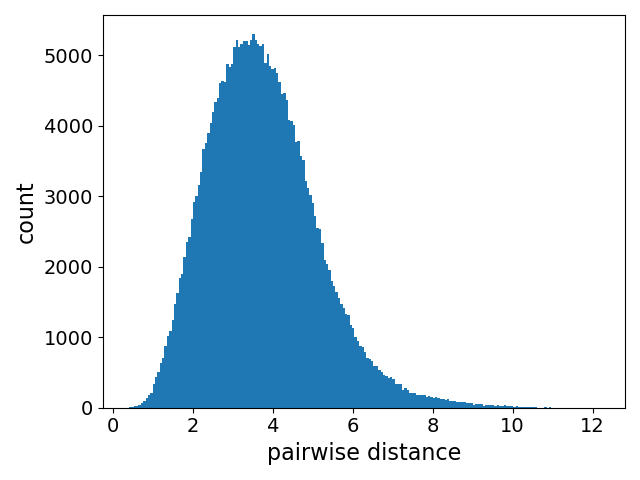

In [45]:
plt.figure()
plt.tick_params(labelsize=14)
plt.hist(dist, bins=200)
plt.xlabel('pairwise distance', fontsize=16)
plt.ylabel('count', fontsize=16)
plt.tight_layout()
plt.show()

This plot gives us a crude idea how to set `eps`. For example, values (far) above the average are likely to yield a single big cluster; try `eps=4`. On the other hand, values close to 0 are arguably to small to result in to many noise points and very small clusters. Note that these values will also depend whether the attributes have been standardized or not!!!

In [46]:
dbscan_diabetes = DBSCAN(eps=1, min_samples=5).fit(X_diabetes) 

print(np.unique(dbscan_diabetes.labels_))

[-1  0  1  2  3]


### Visualization

As our dataset now has more than 3 attributes, we cannot direct plot the clusters. However, we can use dimensionality reduction techniques to map the data points into a lower-dimensional space. In this example, we use PCA to map our data into 2d -- a detailed discussion about PCA is beyond the scope of this notebook.

In [47]:
X_diabetes_pca = PCA(n_components=2).fit_transform(X_diabetes)
X_diabetes_tsne = TSNE(n_components=2).fit_transform(X_diabetes)

<IPython.core.display.Javascript object>


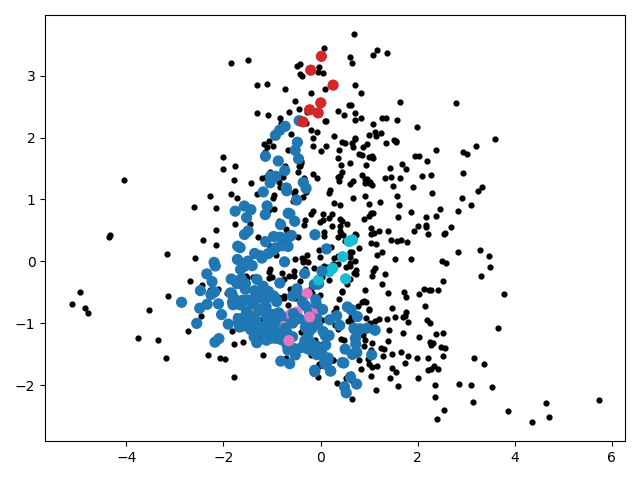

In [48]:
plot_clusters(dbscan_diabetes, X_diabetes_pca)

<IPython.core.display.Javascript object>


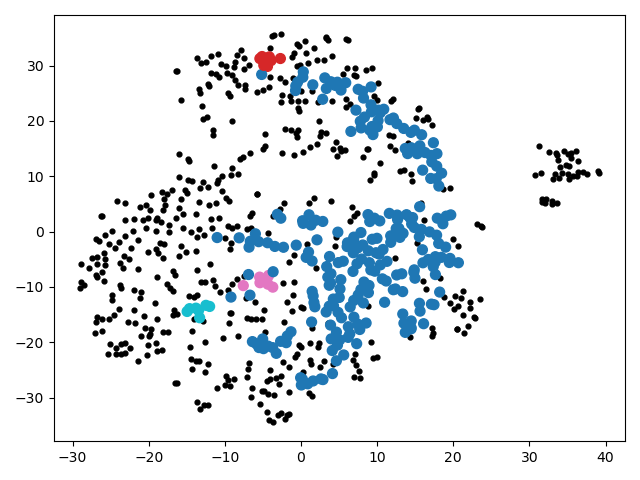

In [49]:
plot_clusters(dbscan_diabetes, X_diabetes_tsne)

Independent from the different result or PCA and t-SNE, the clusters do no really look as expected. The issue is that dimensionality reduction always result in the loss of information. Just note the t-SNE is probabilistic, so different runs will yield different results/plots.

## Location Data

DBSCAN is particularly interesting for dataset where we already know or expect the data not to be blobs but of different shapes. A good example is location data, where bus stops or bars might cluster along a popular road. Of course, bars or restaurants might also occur in the shape of blobs in popular areas.

The following CSV file contains a list of places/venues with their type and geographic location in terms of latitude-longitude pairs.

In [50]:
# This CSV file has not header line at the top, so the columns will be unnamed
# but if you look at the data you should identify the meaning of each column
df = pd.read_csv('data/sg-places.csv', header=None)

Let's have a look at all possible values for Column 2, which reflects the type of a place, just to see what's available to us. You can of course consider all places, but things get quickly too cluttered.

In [51]:
print(set(df[2]))

{'department_store', 'gym', 'doctor', 'fire_station', 'atm', 'local_government_office', 'furniture_store', 'aquarium', 'night_club', 'bank', 'painter', 'general_contractor', 'stadium', 'hardware_store', 'storage', 'establishment', 'church', 'car_wash', 'health', 'zoo', 'amusement_park', 'city_hall', 'hdb', 'home_goods_store', 'pet_store', 'courthouse', 'police', 'locksmith', 'bowling_alley', 'roofing_contractor', 'accounting', 'bar', 'lawyer', 'plumber', 'cafe', 'real_estate_agency', 'subway_station', 'meal_takeaway', 'movie_rental', 'lodging', 'park', 'car_rental', 'clothing_store', 'shopping_mall', 'physiotherapist', 'electrician', 'restaurant', 'meal_delivery', 'mosque', 'embassy', 'florist', 'grocery_or_supermarket', 'art_gallery', 'jewelry_store', 'university', 'electronics_store', 'parking', 'bicycle_store', 'laundry', 'book_store', 'car_repair', 'cemetery', 'liquor_store', 'museum', 'place_of_worship', 'convenience_store', 'veterinary_care', 'natural_feature', 'travel_agency', '

Let's pick all the places of one type. The descriptions in the following well refer to restaurants (in more detail: McDonald's restaurants; see below). But feel free to change the type to anything of your interest.

In [52]:
# Try different place types
place_type = 'restaurant'
#place_type = 'bus_station'
#place_type = 'subway_station' # MRT+LRT stations
#place_type = 'store'

df_places = df[df[2]==place_type]

print('Number of places: {}'.format(df_places.shape[0]))

df_places.head()

Number of places: 3028


,0,1,2,3,4
5,Néktar,"31 Scotts Road, Singapore",restaurant,1.310800,103.835050
26,Eatzi Gourmet Restaurant,"Yishun Avenue 4, Singapore",restaurant,1.423845,103.840826
29,Pin Si Restaurant,"60 Yishun Avenue 4, Singapore",restaurant,1.424458,103.840466
48,Loving Hut 3 Pte Ltd,"90 Yishun Central, Singapore",restaurant,1.424031,103.838400
52,Chin Huat Live Seafood Pte Ltd,"105 Clementi Street 12, Singapore",restaurant,1.322638,103.770091


3k+ restaurants is quite a lot, and maybe even to diverse for an analysis. So let's further filter the dataset to only include McDonald's restaurants. We use regular expression for that. No worries, if you're not familiar with regular expressions, as they won't be needed for any assignments or the project (although that might depend on your approaches)

In [53]:
p = re.compile(r'mcdonald', flags=re.IGNORECASE)
df_places = df_places[[bool(p.search(x)) for x in df_places[0]]]

df_places.head()

,0,1,2,3,4
25532,McDonald\'s City Square Mall,"180 Kitchener Rd, #B1-03, Singapore",restaurant,1.311738,103.856359
29790,McDonald\'s Centrepoint,"176 Orchard Road, #B1-02 & #B1-101/102/103 Cen...",restaurant,1.300904,103.839656
31808,McDonald\'s Ang Mo Kio,"51 Ang Mo Kio Avenue 3, Singapore",restaurant,1.369226,103.847195
60547,McDonald\'s Bukit Panjang Plaza,"1 Jelebu Rd #02-01, Singapore",restaurant,1.379953,103.764188
60548,McDonald\'s,"Bukit Panjang Plaza, Singapore",restaurant,1.379656,103.764438


### Visualize the Data

In [54]:
num_restaurants, num_attributes = df_places.shape

print('Number of places: {}'.format(num_restaurants))

Number of places: 141


We need to convert the column containing latitude and longitude to a matrix, i.e., a 2d numpy array for further processing. Note that the resulting order is \[longitude, latitude\], since longitude represent the x variable and latitude the y variable. This doesn't matter for the clustering but it ensures that the plots look alright and are not rotated by 90 degrees

In [55]:
X_places = df_places[[4, 3]].to_numpy()

print(X_places[0])

[103.856359   1.311738]


This is a neat way that the proportions of the plotted points look nicer. Otherwise, the induced shape of Singapore will be squashed. Since Singapore is so close to the equator, this correction is not really needed, though.

In [56]:
aspect = 1/np.cos(np.radians(1.35))
print(aspect)

1.0002776468483747


Let's plot all the places (e.g., the 141 McDonald's restaurant). You should be able to recognize the outline of Singapore. Of course, if you pick place types that are much less common and/or can only be found in certain areasm you won't be able to "see" the outline of Singapore

<IPython.core.display.Javascript object>


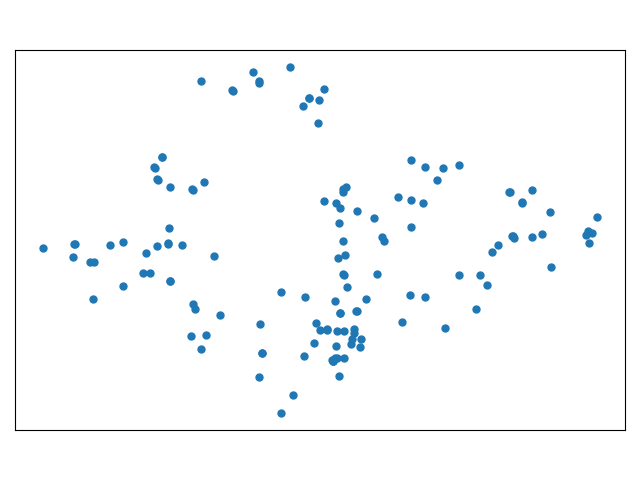

In [57]:
plt.figure()
plt.axes().set_aspect(aspect)
plt.scatter(X_places[:,0], X_places[:,1], s=25)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)  
plt.tight_layout()
plt.show()

### Performing DBSCAN

By default, the DBSCAN implementation of scikit-learn, would treat the latitude-longitude pairs as coordinates in the Euclidean space. DBSCAN would still work fine, but we would have a hard time to pick intuitive values for `eps`. The Euclidean distance between to geolocations has no meaningful unit such as meter or kilometer.

Luckily, DBSCAN allows us to provide a custom similarity/distance metric. The method below calculates the distance between 2 geolocations in meter; this function can be found on the Web.

In [58]:
def geo_distance_in_meters(point1, point2):
    lon1, lat1 = point1[0], point1[1]
    lon2, lat2 = point2[0], point2[1]
    dlon = np.radians(lon2) - np.radians(lon1)
    dlat = np.radians(lat2) - np.radians(lat1)

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance_haversine_formula = 6371000 * c
    return distance_haversine_formula

Now we are ready to run DBSCAN; notice how the method for calculating distances is given as a parameter. With this, we can no express `eps` in meters, making it much more intuitive to pick suitable values -- note that this is a case where we do not want to normalize/standardize the data.

In the example below, we set `eps=500` and `min_samples=5`, which roughly translates to: find clusters with 5 or McDonald's restaurants in a vicinity of 1km (circle with a radius of 500m).

In [59]:
dbscan_places = DBSCAN(metric=geo_distance_in_meters, eps=500, min_samples=5).fit(X_places) 

# The set of unique quickly labels shows how many clusters there are; -1 is noise
print(np.unique(dbscan_places.labels_))

[-1  0  1  2  3  4]


Let's plot the clusters to see where the McDonald's centers of Singapore are :).

<IPython.core.display.Javascript object>


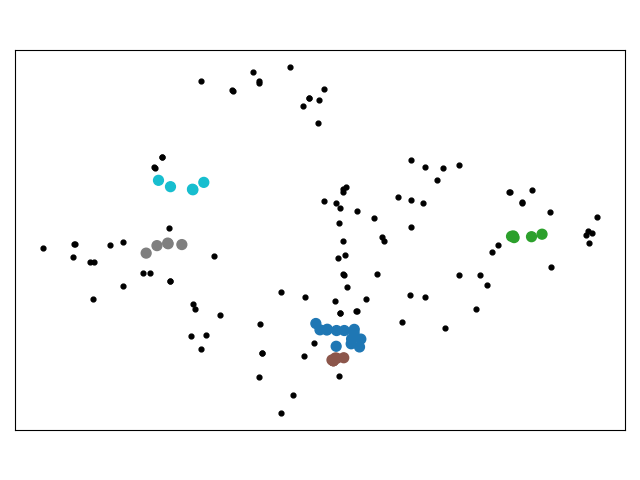

In [60]:
plot_clusters(dbscan_places, X_places, show_ticks=False, point_size=50, aspect=aspect)

There are different Python packages to allow for fancier plot of gelocations on top of actual maps. But those are "only" visualization details which are beyond this notebook.

But note that good visualizations are an important part of data mining to interpret and share results, and you want to keep this in mind for your project :)